# Clustering

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, homogeneity_score
from kneed import KneeLocator
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('data/dataset.csv')
df = df[df['genre'].notnull()]
df = df.drop(['track', 'artist', 'uri'], axis=1)
df.head(5)

danceability  energy  key  loudness  mode  speechiness  acousticness  \
1          0.498   0.505    3   -12.475     1       0.0337        0.0180   
6          0.662   0.272    0   -18.883     1       0.0313        0.3600   
9          0.511   0.603    2    -7.637     1       0.0280        0.0385   
11         0.520   0.411    9   -12.411     1       0.0315        0.7860   
13         0.746   0.666    2   -10.408     1       0.1460        0.5430   

    instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
1           0.107000    0.1760    0.797  101.801       213613               4   
6           0.228000    0.0963    0.591  143.507       134360               4   
9           0.000002    0.1420    0.685  128.336       157293               4   
11          0.001200    0.1460    0.350  120.290       207573               4   
13          0.000000    0.0488    0.840   94.024       192427               4   

    chorus_hit  sections  target  decade    genre  
1     48.82510        10       0      60      pop  
6     47.82155         7       0      60     jazz  
9     43.36534         9       1      60      pop  
11    37.54527         9       1      60      pop  
13    78.59848         5       1      60  country

## Scale data

In [3]:
scaler = StandardScaler()
X = df.drop(['decade','genre'],axis=1)
X = scaler.fit_transform(X)
y_decade = df['decade']
y_genre = df['genre']

## Visualizations

In [4]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

<AxesSubplot:>

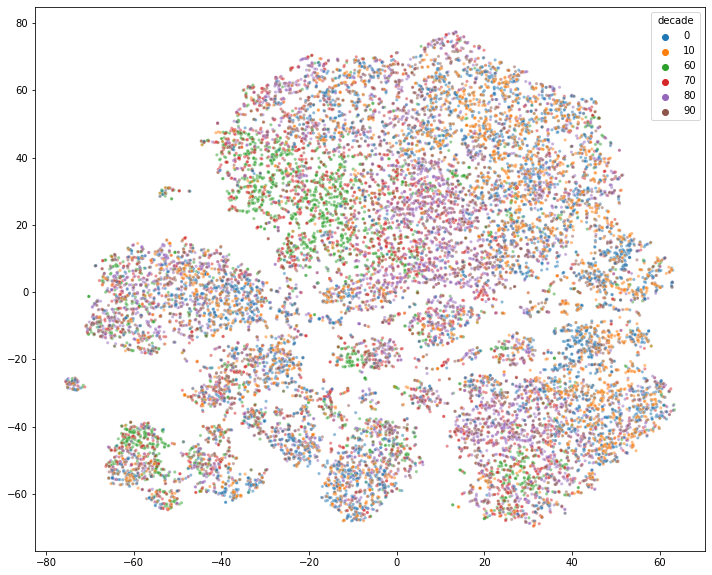

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=y_decade,
    palette='tab10',
    s=10,
    alpha=0.5,
    ax=ax
)

<AxesSubplot:>

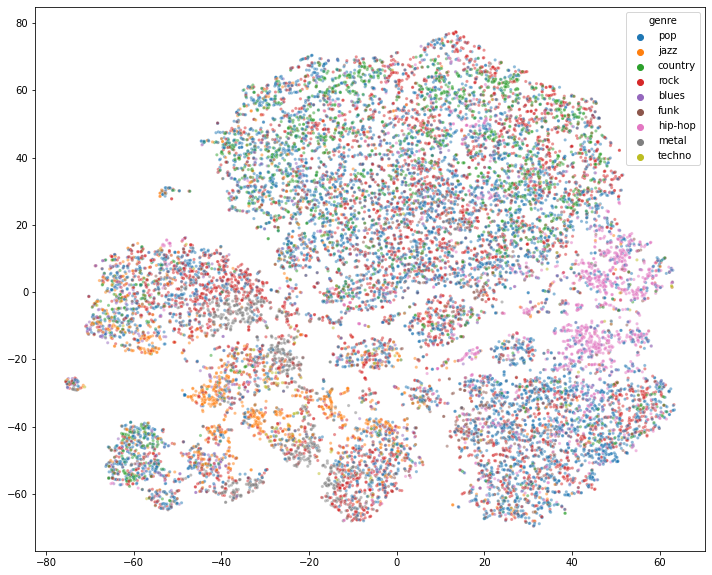

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=y_genre,
    palette='tab10',
    s=10,
    alpha=0.5,
    ax=ax
)

## Helper functions

In [7]:
def plot_pca_scatter(X, y, y_pred):
    tsne = TSNE(n_components=2, random_state=0)
    X_tsne = tsne.fit_transform(X)
    fig, axs = plt.subplots(2, figsize=(12, 20))
    print(f'Homogeneity score: {homogeneity_score(y, y_pred)}')
    sns.scatterplot(
        x=X_tsne[:,0],
        y=X_tsne[:,1],
        hue=y,
        palette='tab10',
        s=10,
        alpha=0.5,
        ax=axs[0]
    ).set_title('Original')
    sns.scatterplot(
        x=X_tsne[:,0],
        y=X_tsne[:,1],
        hue=y_pred,
        palette='tab10',
        s=10,
        alpha=0.5,
        ax=axs[1]
    ).set_title('Predicted')

In [8]:
num_genres = len(y_genre.unique())
num_decades = len(y_decade.unique())

## K means

Homogeneity score: 0.04130239146182497


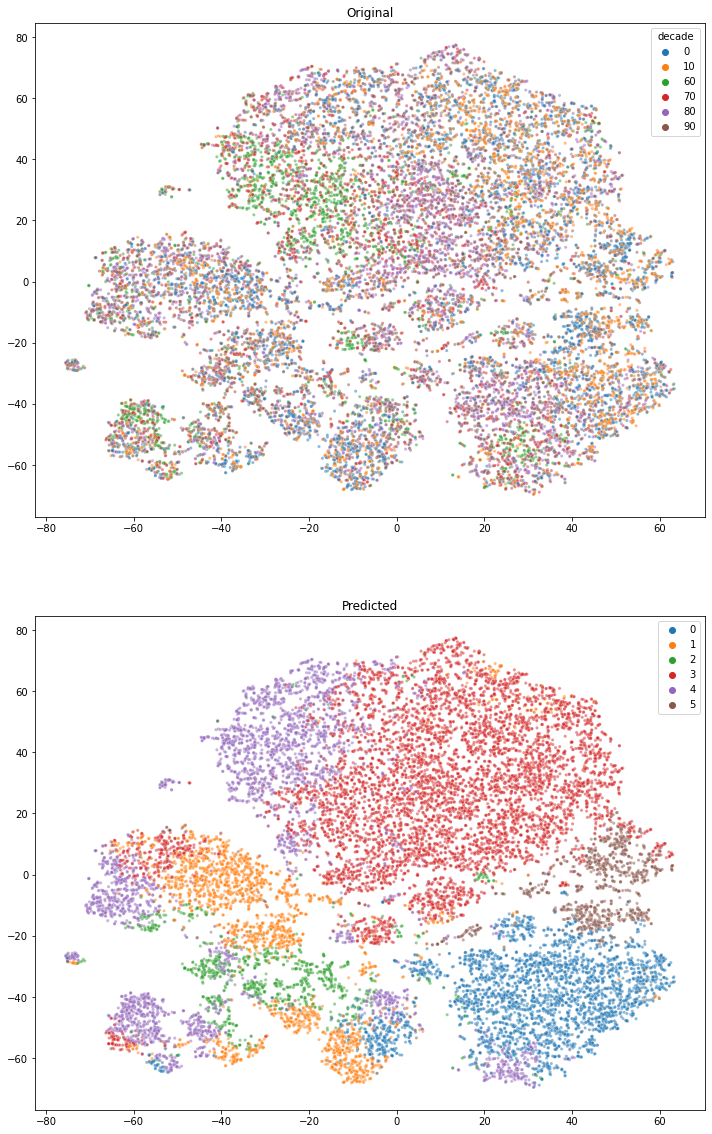

In [9]:
model_decades = KMeans(n_clusters=num_decades, random_state=0)
model_decades.fit(X)
plot_pca_scatter(X, y_decade, model_decades.predict(X))

Homogeneity score: 0.15500305759594268


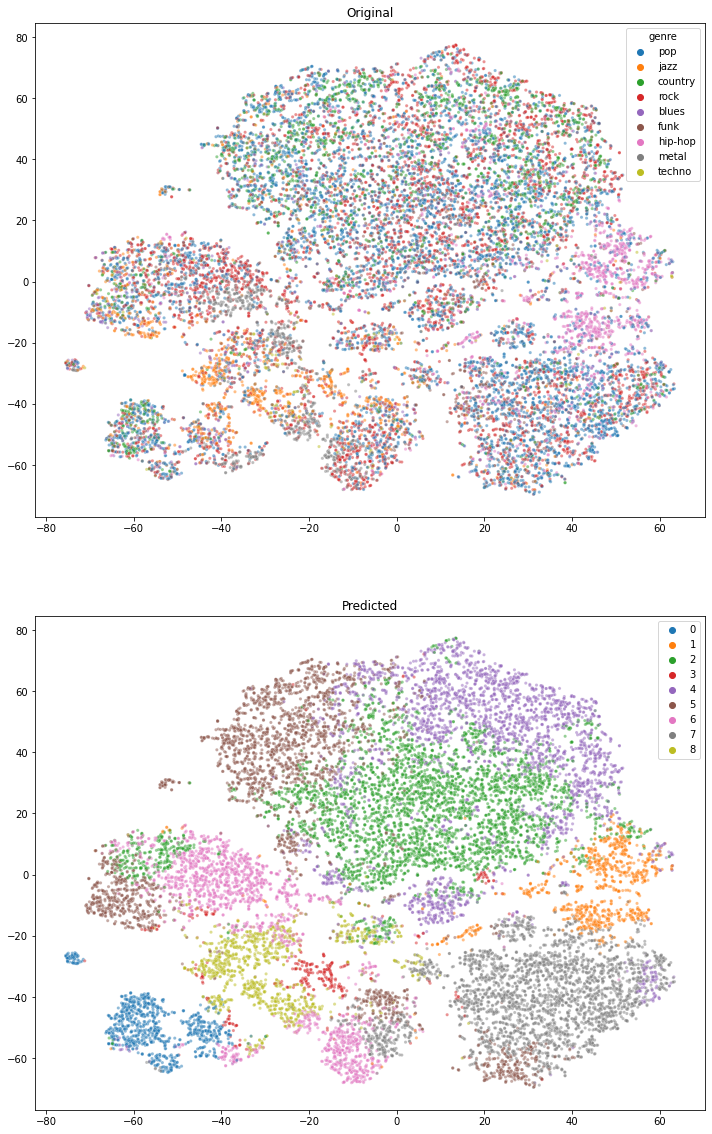

In [10]:
model_genres = KMeans(n_clusters=num_genres, random_state=0)
model_genres.fit(X)
plot_pca_scatter(X, y_genre, model_genres.predict(X))

### Using knee locator to find best parameter

In [11]:
SSE = []
sil_coef = []
for i in range(1, max(num_genres, num_decades)):
    k_m = KMeans(n_clusters=i)
    k_m.fit(X)
    SSE.append(k_m.inertia_)
    if i > 1:
        score = silhouette_score(X, k_m.labels_)
        sil_coef.append(score)

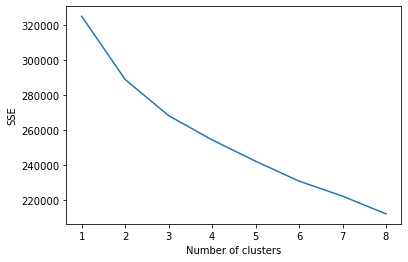

In [12]:
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.plot(range(1, max(num_genres, num_decades)), SSE)

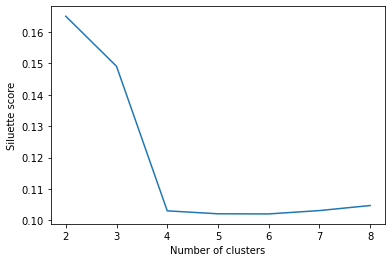

In [13]:
plt.xlabel('Number of clusters')
plt.ylabel('Siluette score')
plt.plot(range(2, max(num_genres, num_decades)), sil_coef)

In [14]:
kl = KneeLocator(range(1, max(num_genres, num_decades)), SSE, curve='convex', direction='decreasing')
kl.elbow

3

Homogeneity score: 0.03226010912016205


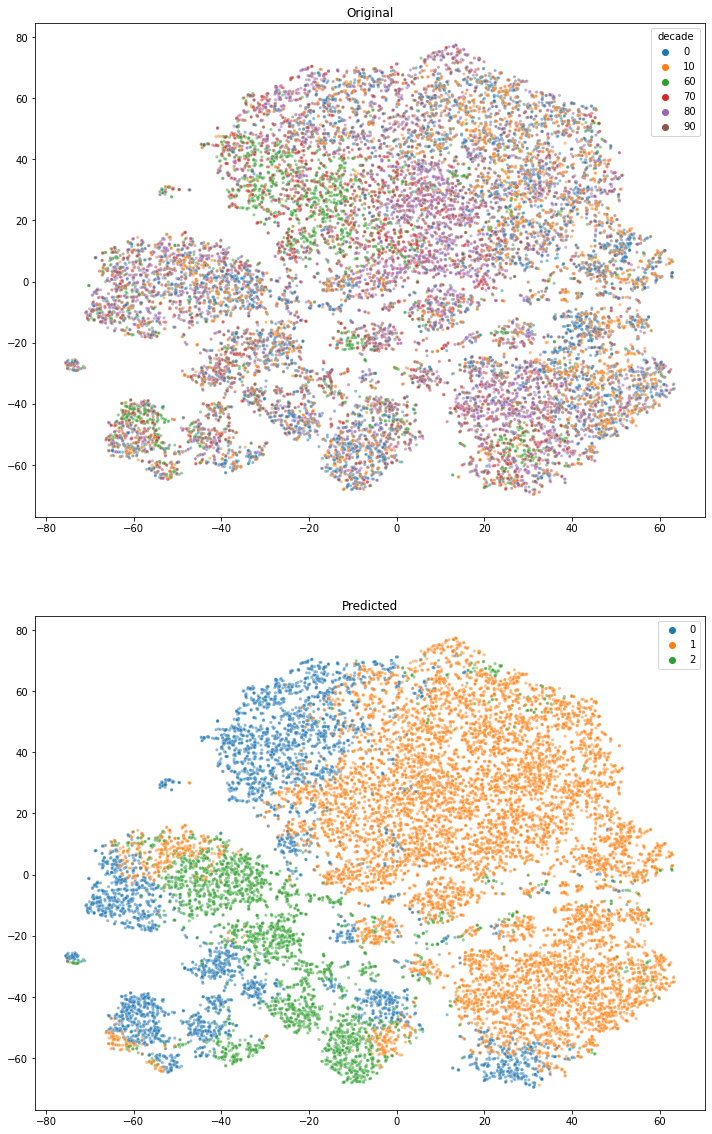

In [15]:
best_cluster_model = KMeans(n_clusters = kl.elbow)
best_cluster_model.fit(X)
plot_pca_scatter(X, y_decade, best_cluster_model.predict(X))

## Hierarchical (Agglomerative)

Homogeneity score: 0.12303073726262057


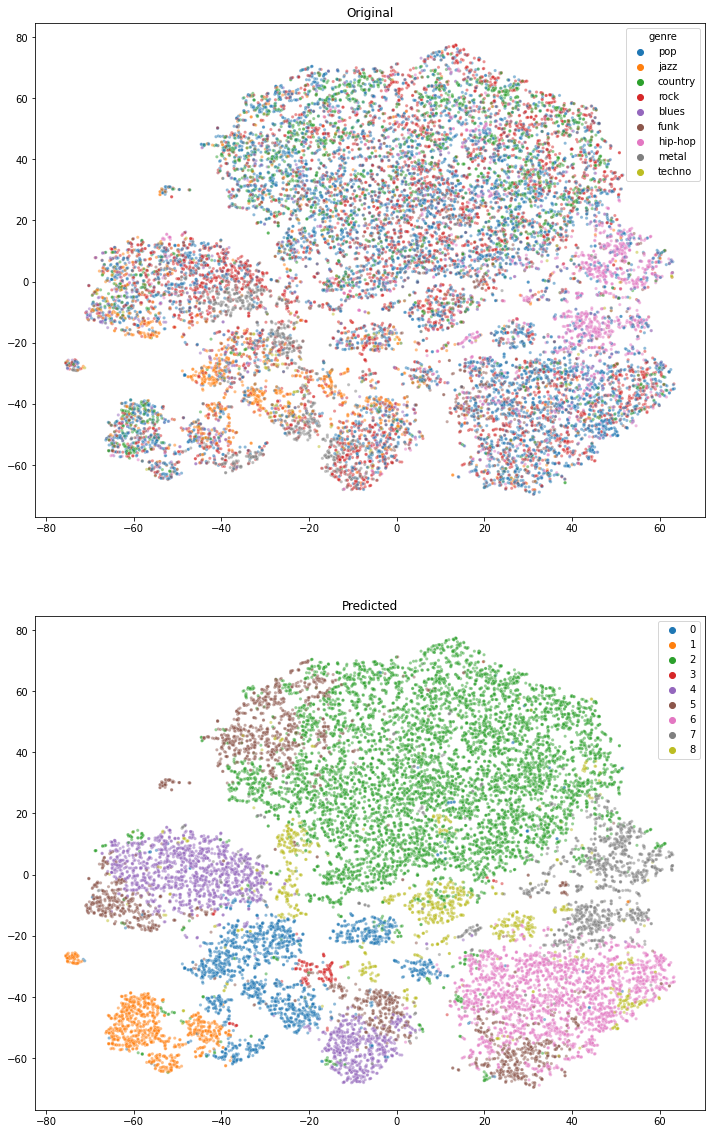

In [16]:
ac_genres = AgglomerativeClustering(n_clusters=num_genres)
ac_genres.fit(X)
plot_pca_scatter(X, y_genre, ac_genres.labels_)

## DBSCAN


### Using KNN to choose eps

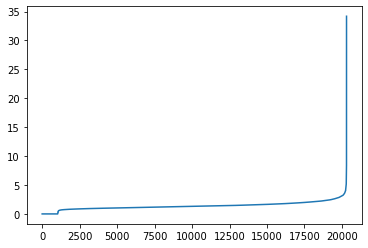

In [17]:
model_knn = NearestNeighbors(n_neighbors=2)
model_knn.fit(X)
distances, indices = model_knn.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [18]:
min_samples = 2 * X.shape[1]

Homogeneity score: 0.014652258188430202


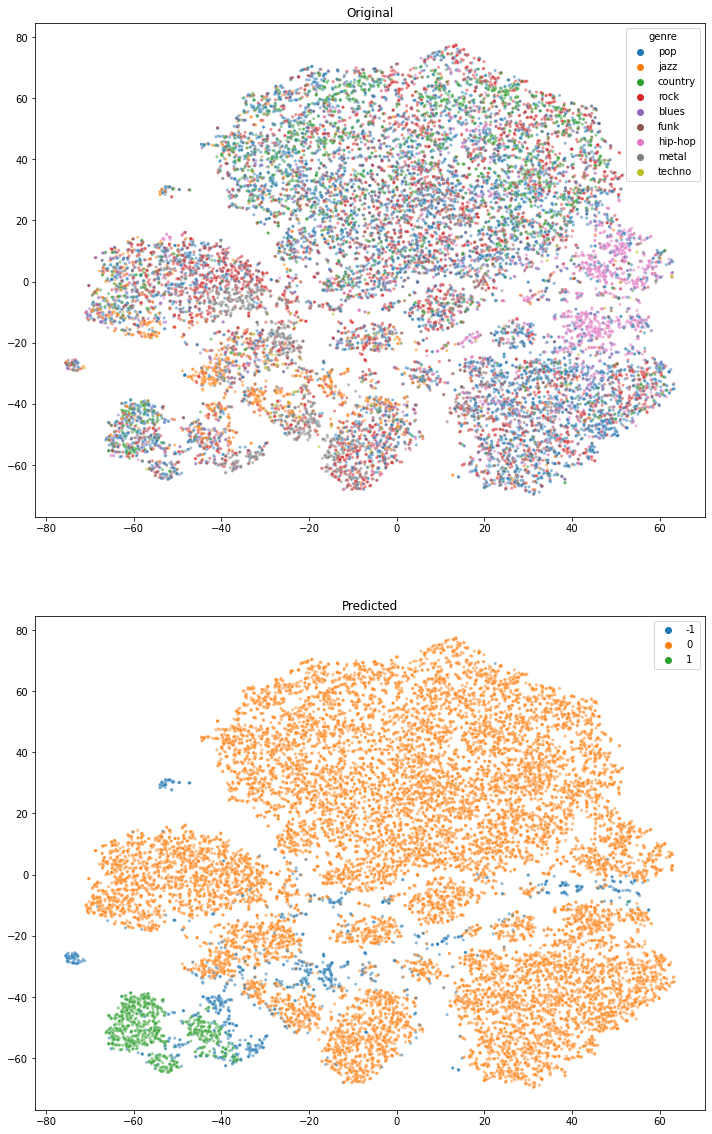

In [19]:
db = DBSCAN(eps=3, min_samples=min_samples)
db.fit(X)
plot_pca_scatter(X, y_genre, db.labels_)

### Trying different eps

<AxesSubplot:>

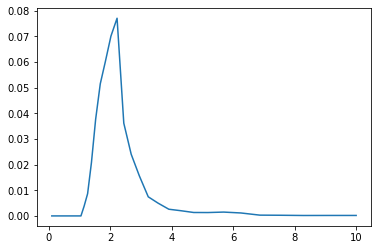

In [20]:
scores = []
eps_range = np.logspace(-1, 1, 50)
for eps in eps_range:
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(X)
    y_pred = model.labels_
    scores.append(homogeneity_score(y_genre, y_pred))
sns.lineplot(x=eps_range, y=scores)

In [21]:
df_eps_scores = pd.DataFrame({'Eps': eps_range, 'Score': scores})
df_eps_scores

Eps         Score
0    0.100000  3.929222e-17
1    0.109854  3.929222e-17
2    0.120679  3.929222e-17
3    0.132571  3.929222e-17
4    0.145635  3.929222e-17
5    0.159986  3.929222e-17
6    0.175751  3.929222e-17
7    0.193070  3.929222e-17
8    0.212095  3.929222e-17
9    0.232995  3.929222e-17
10   0.255955  3.929222e-17
11   0.281177  3.929222e-17
12   0.308884  3.929222e-17
13   0.339322  3.929222e-17
14   0.372759  3.929222e-17
15   0.409492  3.929222e-17
16   0.449843  3.929222e-17
17   0.494171  3.929222e-17
18   0.542868  3.929222e-17
19   0.596362  3.929222e-17
20   0.655129  3.929222e-17
21   0.719686  3.929222e-17
22   0.790604  3.929222e-17
23   0.868511  3.929222e-17
24   0.954095  3.929222e-17
25   1.048113  3.929222e-17
26   1.151395  3.799994e-03
27   1.264855  8.660889e-03
28   1.389495  2.078437e-02
29   1.526418  3.768423e-02
30   1.676833  5.150022e-02
31   1.842070  6.016174e-02
32   2.023590  7.009327e-02
33   2.222996  7.707010e-02
34   2.442053  3.614846e-02
35   2.682696  2.404103e-02
36   2.947052  1.563419e-02
37   3.237458  7.448183e-03
38   3.556480  4.985271e-03
39   3.906940  2.607420e-03
40   4.291934  2.038189e-03
41   4.714866  1.335943e-03
42   5.179475  1.316933e-03
43   5.689866  1.494250e-03
44   6.250552  1.150048e-03
45   6.866488  3.038222e-04
46   7.543120  2.561551e-04
47   8.286428  1.662513e-04
48   9.102982  1.818139e-04
49  10.000000  1.818139e-04

### Trying best result

In [22]:
best = df_eps_scores.loc[df_eps_scores['Score'].idxmax()]
best

Eps      2.222996
Score    0.077070
Name: 33, dtype: float64

Homogeneity score: 0.07707010446074475


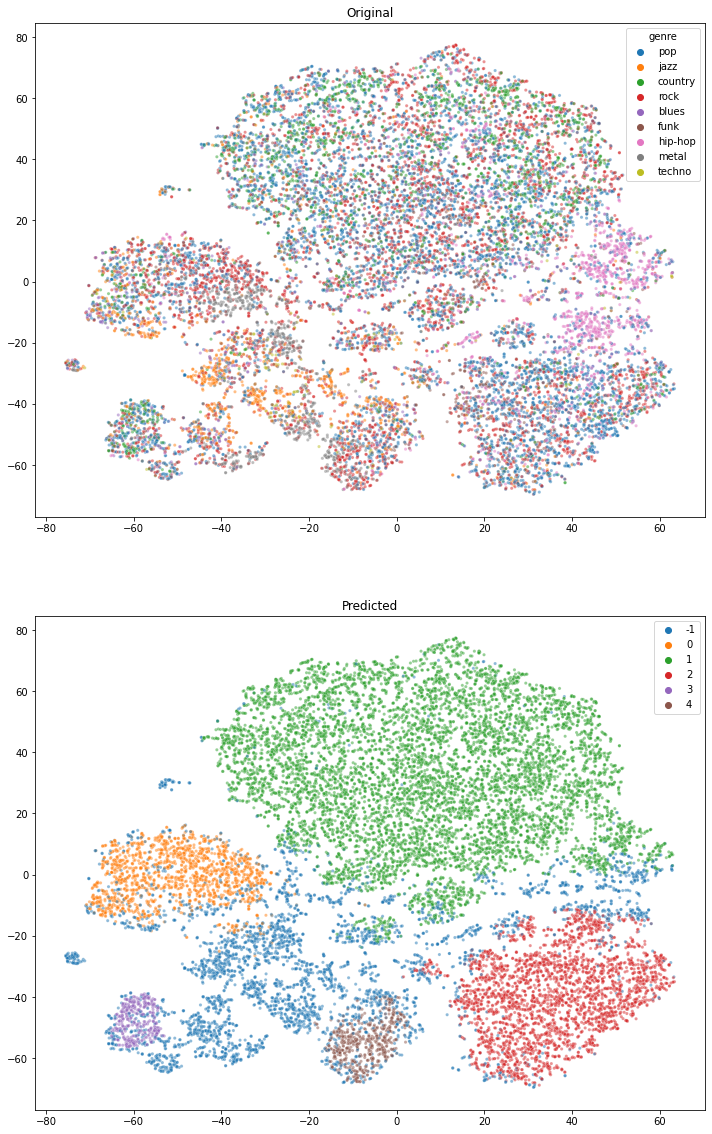

In [23]:
db = DBSCAN(eps=best['Eps'], min_samples=min_samples)
db.fit(X)
plot_pca_scatter(X, y_genre, db.labels_)

## Conclusion

All tested models show poor performance in successfuly matching the original classification of genres in the dataset.